# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [6]:
from pyBasket.common import load_obj
from pyBasket.model import get_patient_model_simple, get_patient_model_hierarchical
from pyBasket.model import get_patient_model_hierarchical_log_odds, get_patient_model_hierarchical_log_odds_nc

## 1. Generate some data

In [7]:
np.random.seed(42)

In [8]:
n_baskets = 25
n_clusters = 5

one_basket_p = np.random.beta(2, 5, size=n_baskets)
true_basket_p = np.tile(one_basket_p, (n_clusters, 1)).T
true_cluster_p = np.random.beta(5, 2, size=(n_baskets, n_clusters))
true_mat = true_basket_p * true_cluster_p

true_basket_p.shape, true_cluster_p.shape, true_mat.shape

((25, 5), (25, 5), (25, 5))

In [9]:
# generate some synthetic data
data = []
for i in range(n_baskets):
    for j in range(n_clusters):
        
        # probability of a patient being responsive in this basket and cluster combination
        p = true_basket_p[i, j] * true_cluster_p[i, j]
        
        # number of patients in this basket and cluster
        n = np.random.randint(1, 5)
        
        # generate the data
        responsive = np.random.binomial(1, p, size=n)
        data += [(i, j, r) for r in responsive]

# convert the data to a pandas dataframe
data = pd.DataFrame(data, columns=['basket_number', 'cluster_number', 'responsive'])
data

basket_number  cluster_number  responsive
0                0               0           0
1                0               0           1
2                0               0           0
3                0               0           0
4                0               1           1
..             ...             ...         ...
296             24               3           0
297             24               4           0
298             24               4           0
299             24               4           0
300             24               4           0

[301 rows x 3 columns]

## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [10]:
n_burn_in = int(1E4)
n_sample = int(1E4)
target_accept = 0.99

### Simple model

In [11]:
data_df = data

In [12]:
basket_coords = data_df['tissues'].unique() if 'tissues' in data_df.columns.values else \
    data_df['basket_number'].unique()
cluster_coords = data_df['cluster_number'].unique()
coords = {'basket': basket_coords, 'cluster': cluster_coords}

with pm.Model(coords=coords) as model_s:
    # prior probability of each basket being responsive
    basket_p = pm.Beta('basket_p', alpha=1, beta=1, dims='basket')

    # prior probability of each cluster being responsive for each basket
    cluster_p = pm.Beta('cluster_p', alpha=1, beta=1, dims=('basket', 'cluster'))

    # responsive is a product of each combination of basket and cluster probabilities
    basket_idx = data_df['basket_number'].values
    cluster_idx = data_df['cluster_number'].values
    is_responsive = data_df['responsive'].values
    y = pm.Bernoulli('y', p=basket_p[basket_idx] * cluster_p[basket_idx, cluster_idx],
                     observed=is_responsive)

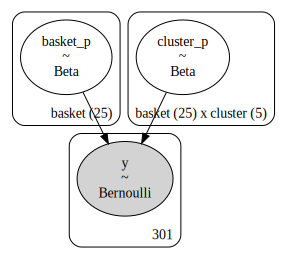

In [13]:
pm.model_to_graphviz(model_s)

In [16]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 132 seconds.


In [17]:
az.summary(trace_s).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
basket_p[0]       0.61  0.19    0.29     0.97        0.0      0.0   47605.0   
basket_p[1]       0.18  0.17    0.00     0.50        0.0      0.0   62263.0   
basket_p[2]       0.82  0.13    0.58     1.00        0.0      0.0   43549.0   
basket_p[3]       0.20  0.18    0.00     0.54        0.0      0.0   63533.0   
basket_p[4]       0.76  0.17    0.45     1.00        0.0      0.0   46392.0   
...                ...   ...     ...      ...        ...      ...       ...   
cluster_p[24, 0]  0.45  0.29    0.00     0.92        0.0      0.0   80474.0   
cluster_p[24, 1]  0.63  0.25    0.21     1.00        0.0      0.0   66200.0   
cluster_p[24, 2]  0.42  0.28    0.00     0.90        0.0      0.0   74092.0   
cluster_p[24, 3]  0.42  0.28    0.00     0.90        0.0      0.0   66813.0   
cluster_p[24, 4]  0.40  0.28    0.00     0.89        0.0      0.0   70997.0   

                  ess_tail  r_hat  
basket_p[0]        24574.0    1.0  
basket_p[1]        26352.0    1.0  
basket_p[2]        24321.0    1.0  
basket_p[3]        25541.0    1.0  
basket_p[4]        24930.0    1.0  
...                    ...    ...  
cluster_p[24, 0]   24505.0    1.0  
cluster_p[24, 1]   22805.0    1.0  
cluster_p[24, 2]   26080.0    1.0  
cluster_p[24, 3]   26291.0    1.0  
cluster_p[24, 4]   27266.0    1.0  

[150 rows x 9 columns]

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (150) in plot_ess, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

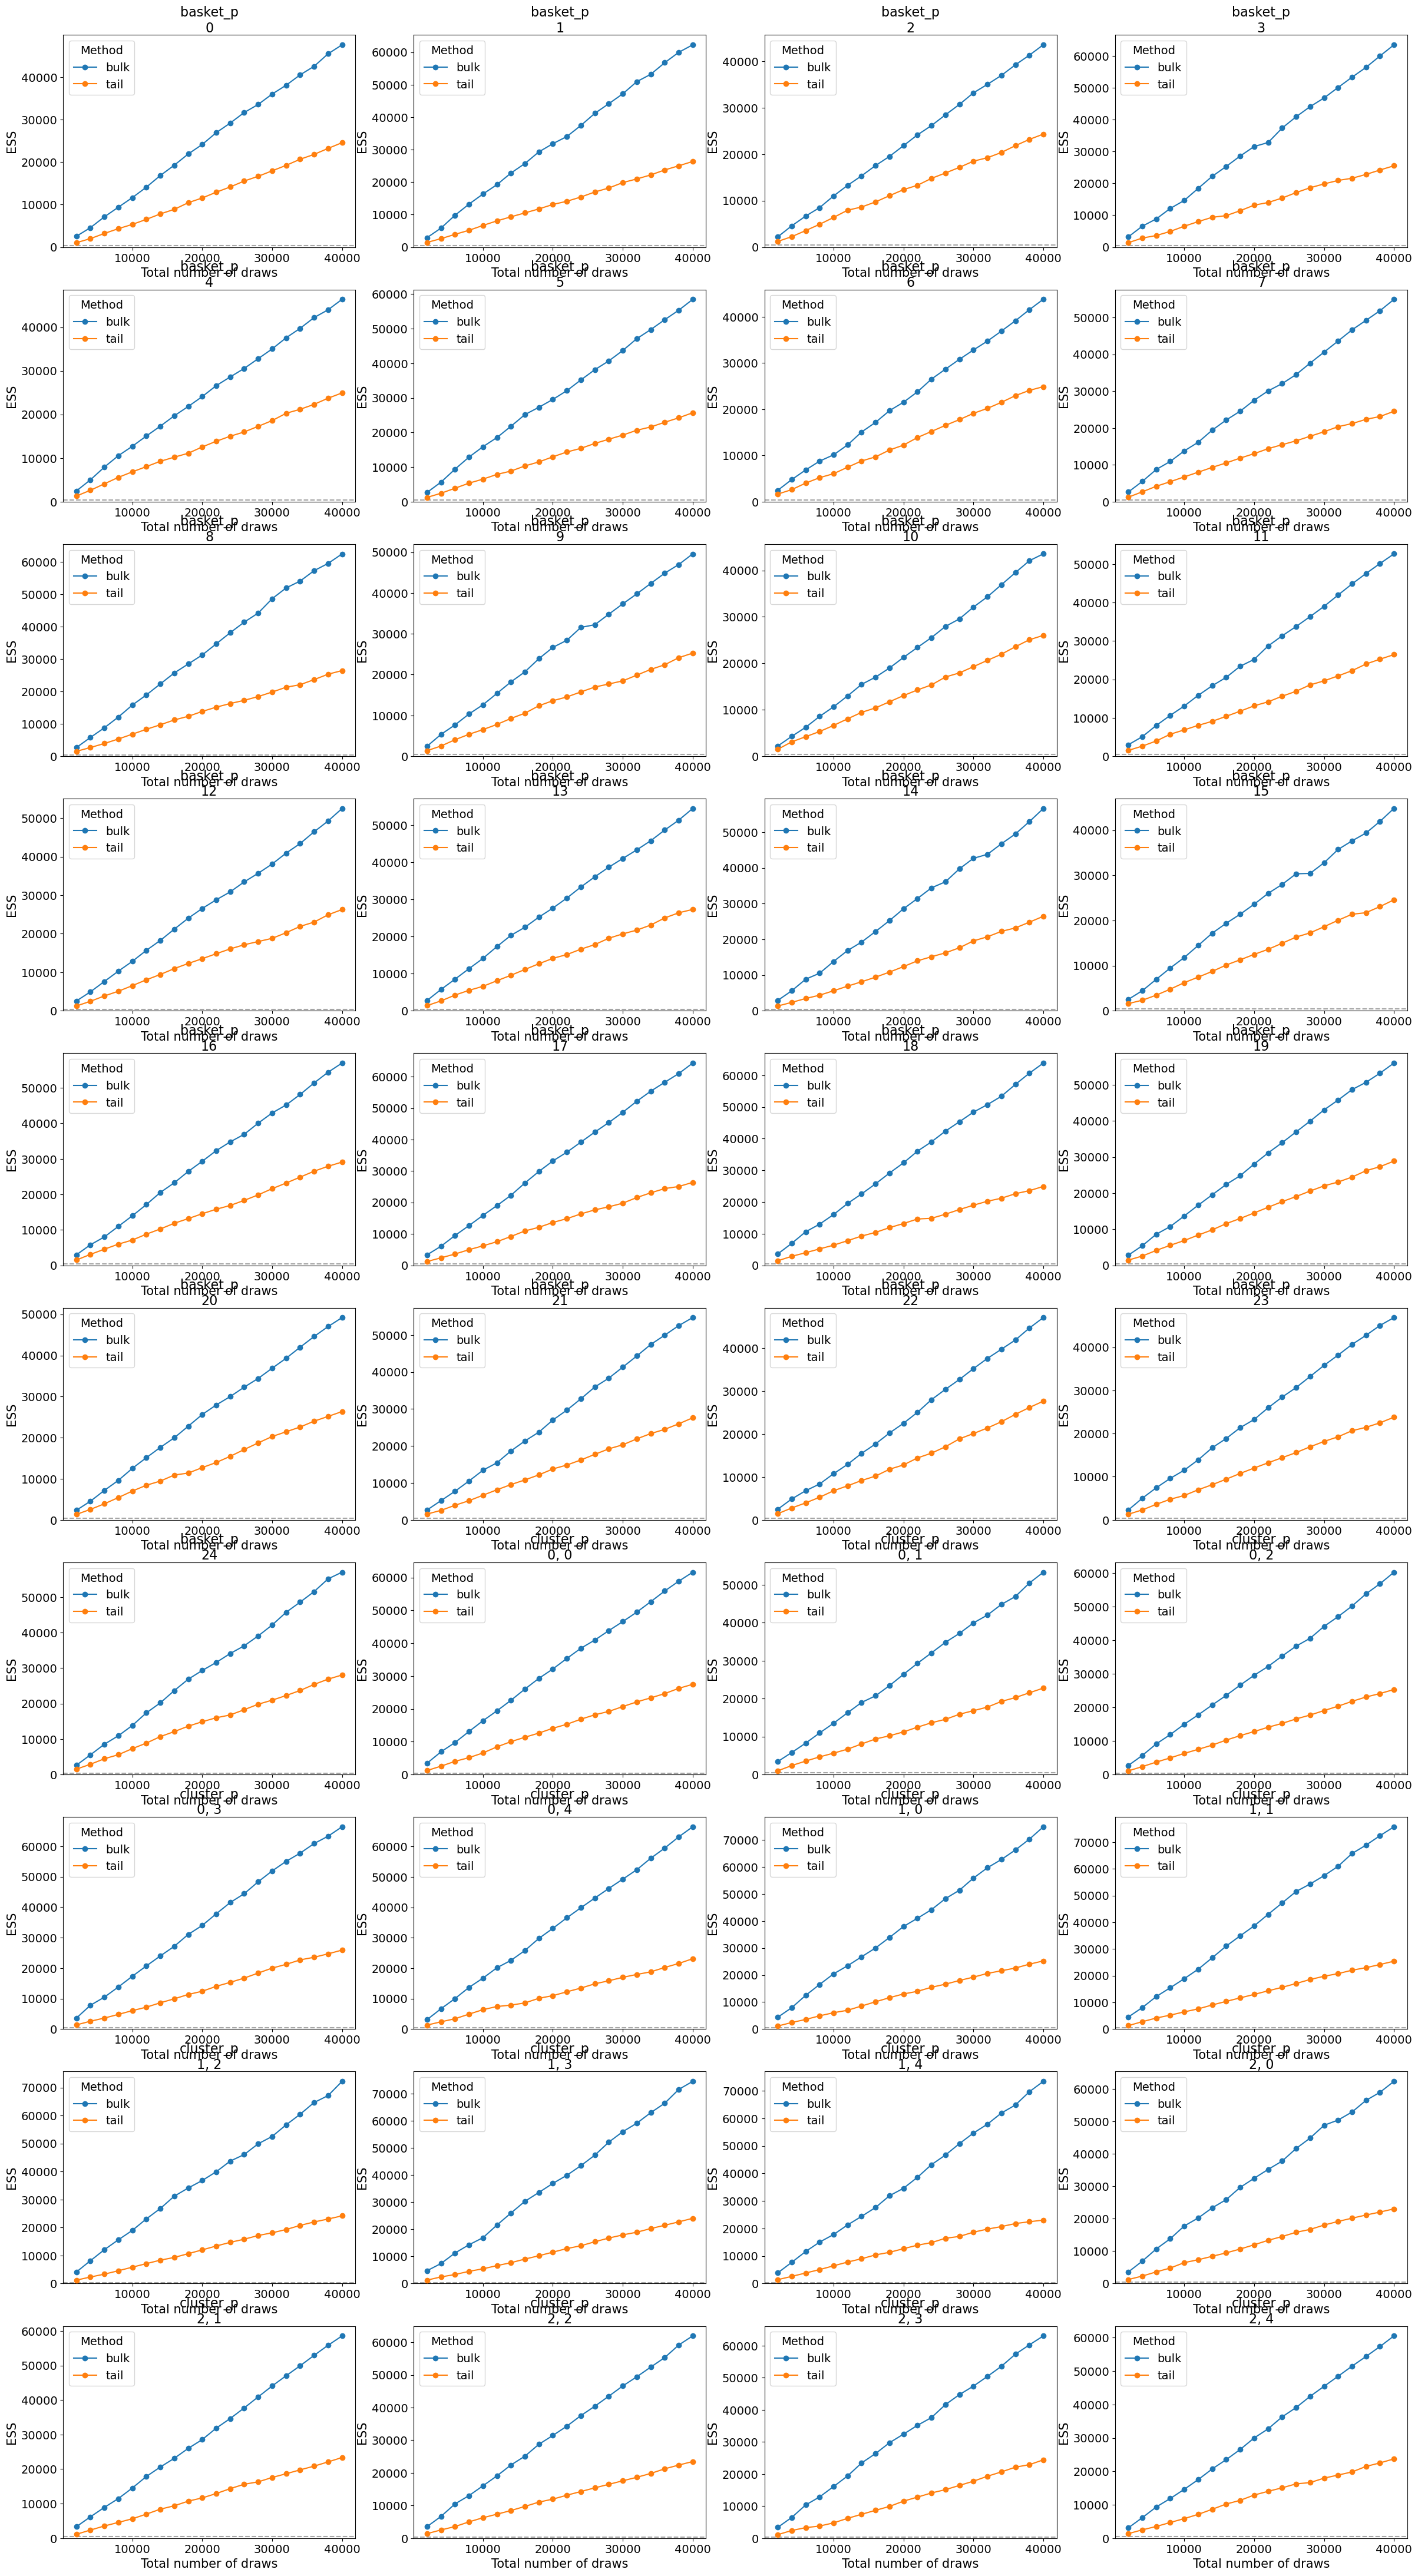

In [18]:
az.plot_ess(
    trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
)

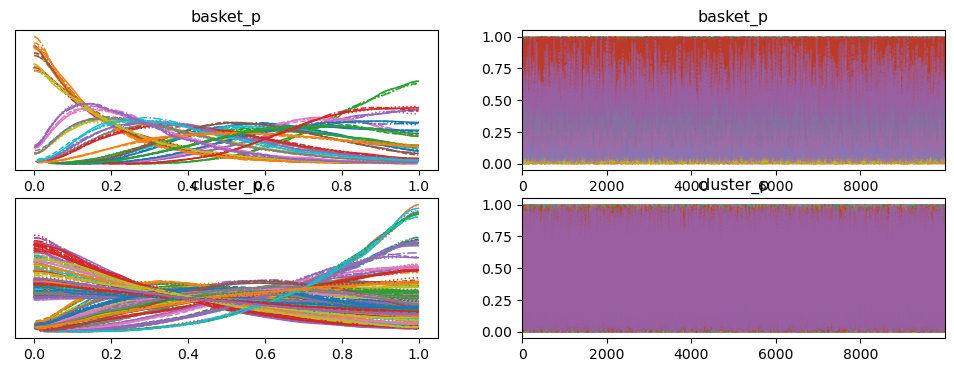

In [19]:
az.plot_trace(trace_s, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

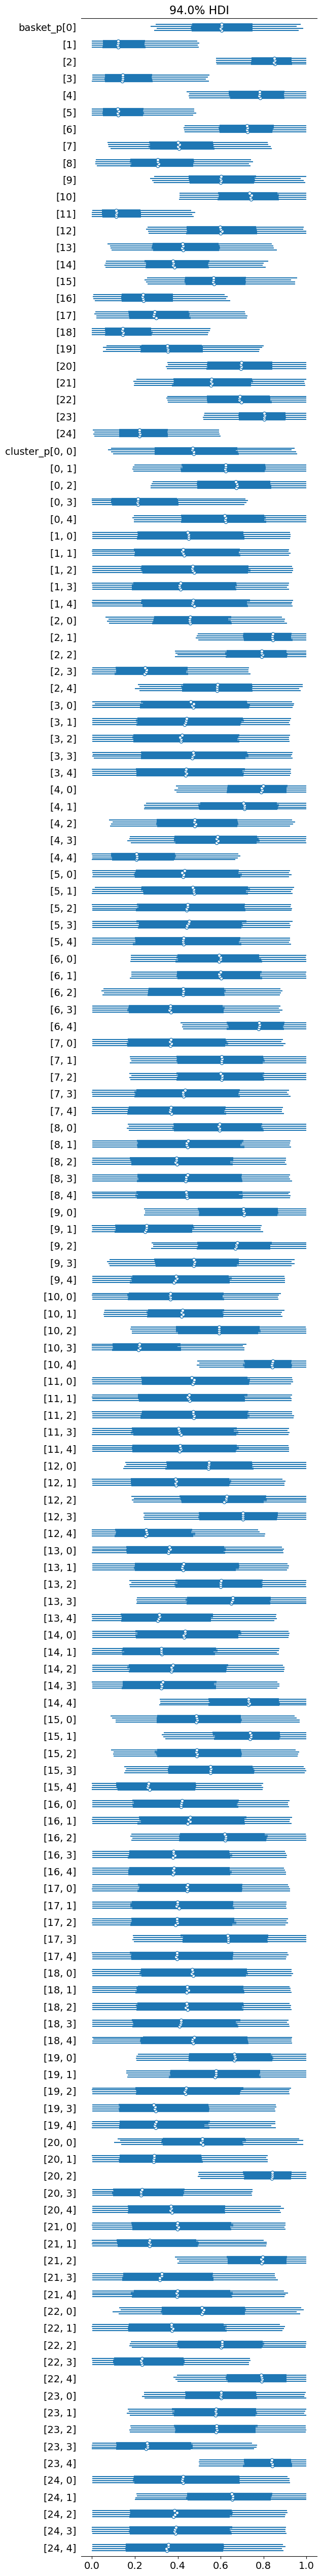

In [20]:
az.plot_forest(trace_s, var_names=['basket_p', 'cluster_p'])

In [55]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p[:, 0].shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p[:, 0], inferred_basket_p))

((25,), (25,), 0.24260321600941948)

In [56]:
inferred_cluster_p = np.mean(stacked_s.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 5), (25, 5), 0.28224015238626754)

In [57]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_s = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 5), (25, 5), (25, 5))

### Hierarchical model 1

This hierarchical model suffers from a lot of divergences. See:
- https://discourse.pymc.io/t/non-centered-parameterization-of-a-beta-distribution/6872/7
- https://stats.stackexchange.com/questions/67443/does-the-beta-distribution-have-a-conjugate-prior

In [48]:
basket_coords = data_df['tissues'].unique() if 'tissues' in data_df.columns.values else \
    data_df['basket_number'].unique()
cluster_coords = data_df['cluster_number'].unique()
coords = {'basket': basket_coords, 'cluster': cluster_coords}

with pm.Model(coords=coords) as model_h1:
    # hyperpriors for basket_p and cluster_p
    basket_alpha = pm.Beta('basket_alpha', alpha=1, beta=1)
    basket_beta = pm.Beta('basket_beta', alpha=1, beta=1)
    cluster_alpha = pm.Beta('cluster_alpha', alpha=1, beta=1)
    cluster_beta = pm.Beta('cluster_beta', alpha=1, beta=1)

    # prior probability of each basket being responsive
    basket_p = pm.Beta('basket_p', alpha=basket_alpha, beta=basket_beta, dims='basket')

    # prior probability of each cluster being responsive for each basket
    cluster_p = pm.Beta('cluster_p', alpha=cluster_alpha, beta=cluster_beta, dims=('basket', 'cluster'))

    # responsive is a product of each combination of basket and cluster probabilities
    basket_idx = data_df['basket_number'].values
    cluster_idx = data_df['cluster_number'].values
    is_responsive = data_df['responsive'].values
    y = pm.Bernoulli('y', p=basket_p[basket_idx] * cluster_p[basket_idx, cluster_idx],
                     observed=is_responsive)

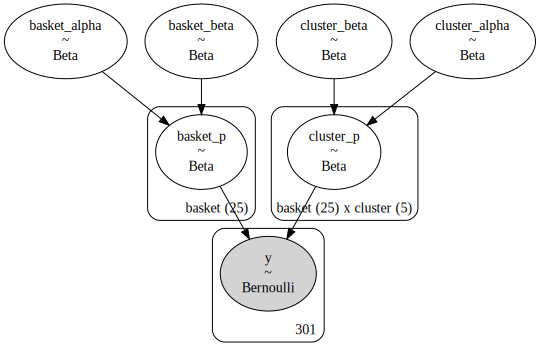

In [49]:
pm.model_to_graphviz(model_h1)

In [50]:
with model_h1:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_alpha, basket_beta, cluster_alpha, cluster_beta, basket_p, cluster_p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 201 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6676, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [51]:
az.summary(trace_h1).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
basket_alpha      0.71  0.17    0.43     1.00        0.0      0.0    8421.0   
basket_beta       0.74  0.18    0.40     1.00        0.0      0.0    3317.0   
cluster_alpha     0.74  0.16    0.48     1.00        0.0      0.0    1239.0   
cluster_beta      0.78  0.16    0.49     1.00        0.0      0.0    2120.0   
basket_p[0]       0.62  0.21    0.30     1.00        0.0      0.0    5478.0   
...                ...   ...     ...      ...        ...      ...       ...   
cluster_p[24, 0]  0.43  0.32    0.00     0.95        0.0      0.0    8986.0   
cluster_p[24, 1]  0.64  0.26    0.18     1.00        0.0      0.0    9592.0   
cluster_p[24, 2]  0.40  0.32    0.00     0.95        0.0      0.0   10059.0   
cluster_p[24, 3]  0.40  0.32    0.00     0.95        0.0      0.0    3001.0   
cluster_p[24, 4]  0.38  0.31    0.00     0.93        0.0      0.0    1869.0   

                  ess_tail  r_hat  
basket_alpha       12078.0   1.00  
basket_beta         2572.0   1.00  
cluster_alpha        403.0   1.01  
cluster_beta        2009.0   1.00  
basket_p[0]         3427.0   1.00  
...                    ...    ...  
cluster_p[24, 0]    7292.0   1.00  
cluster_p[24, 1]   10293.0   1.00  
cluster_p[24, 2]   10676.0   1.00  
cluster_p[24, 3]    1310.0   1.00  
cluster_p[24, 4]     761.0   1.00  

[154 rows x 9 columns]

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (150) in plot_ess, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

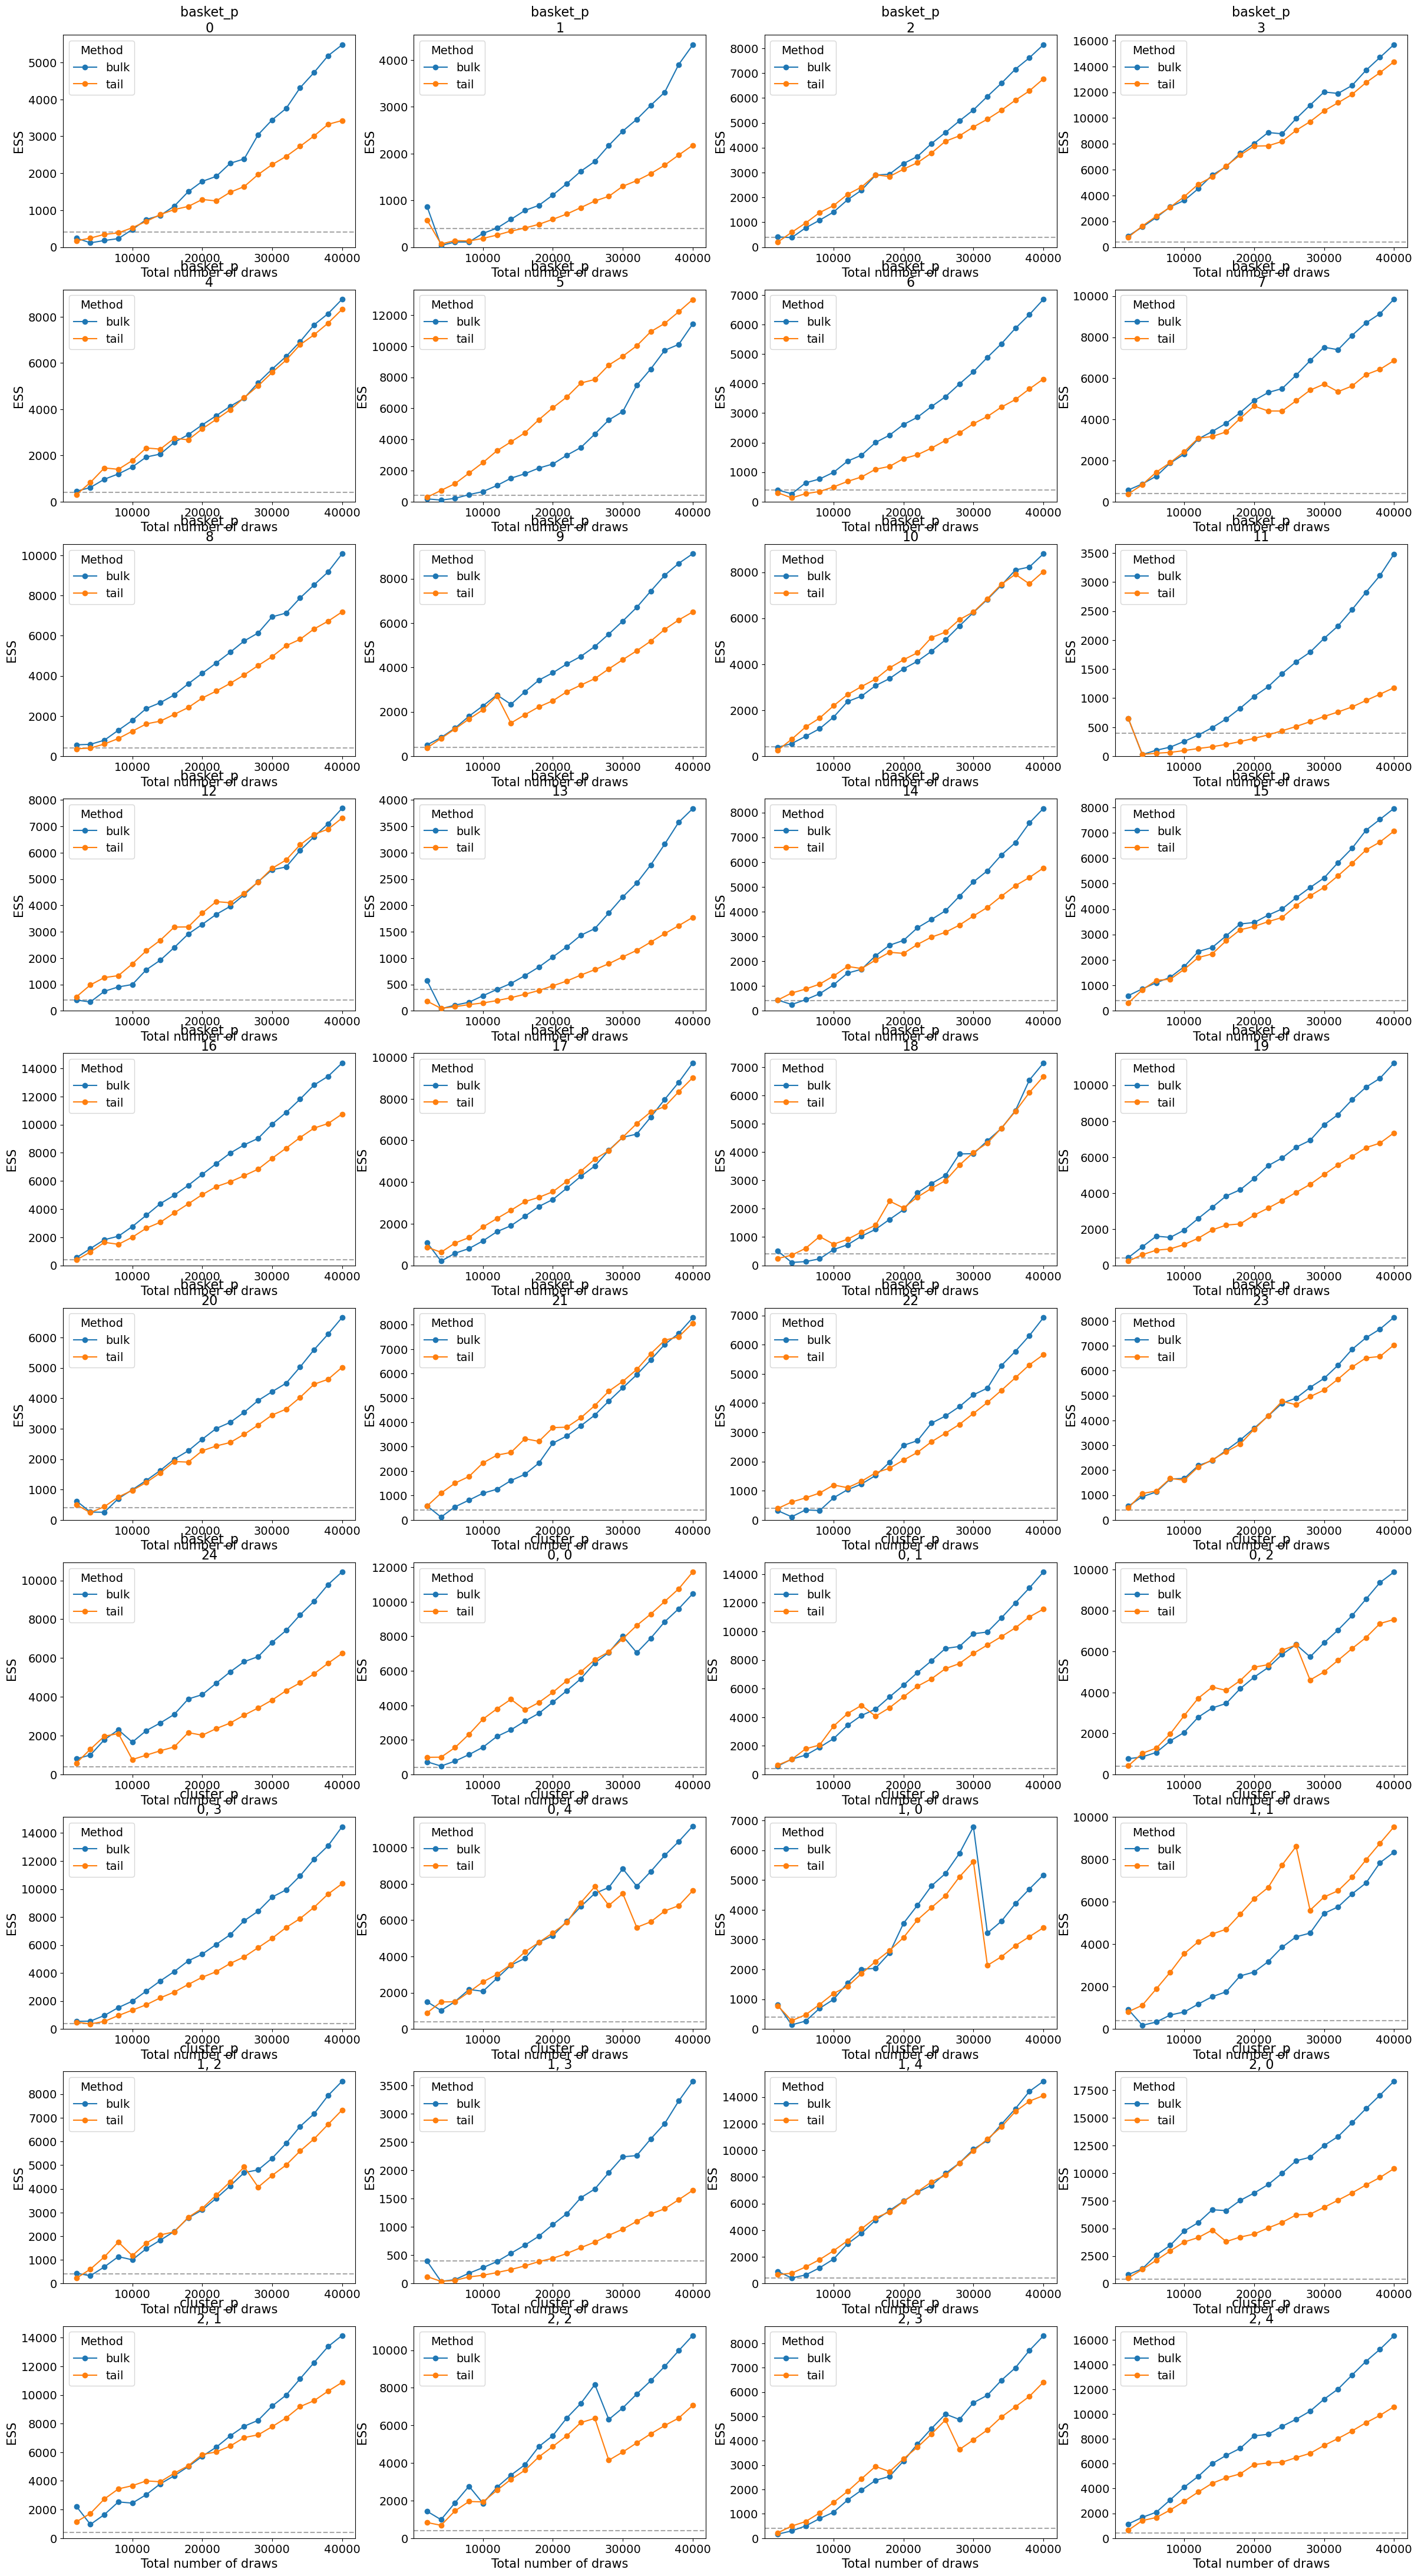

In [52]:
az.plot_ess(
    trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
)

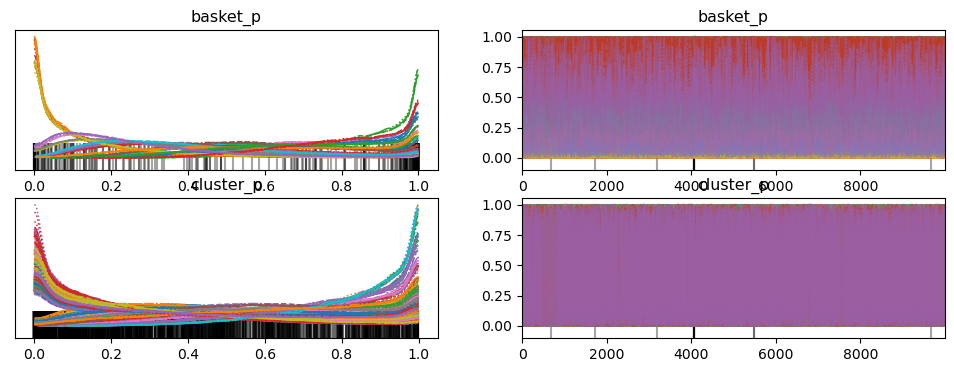

In [53]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

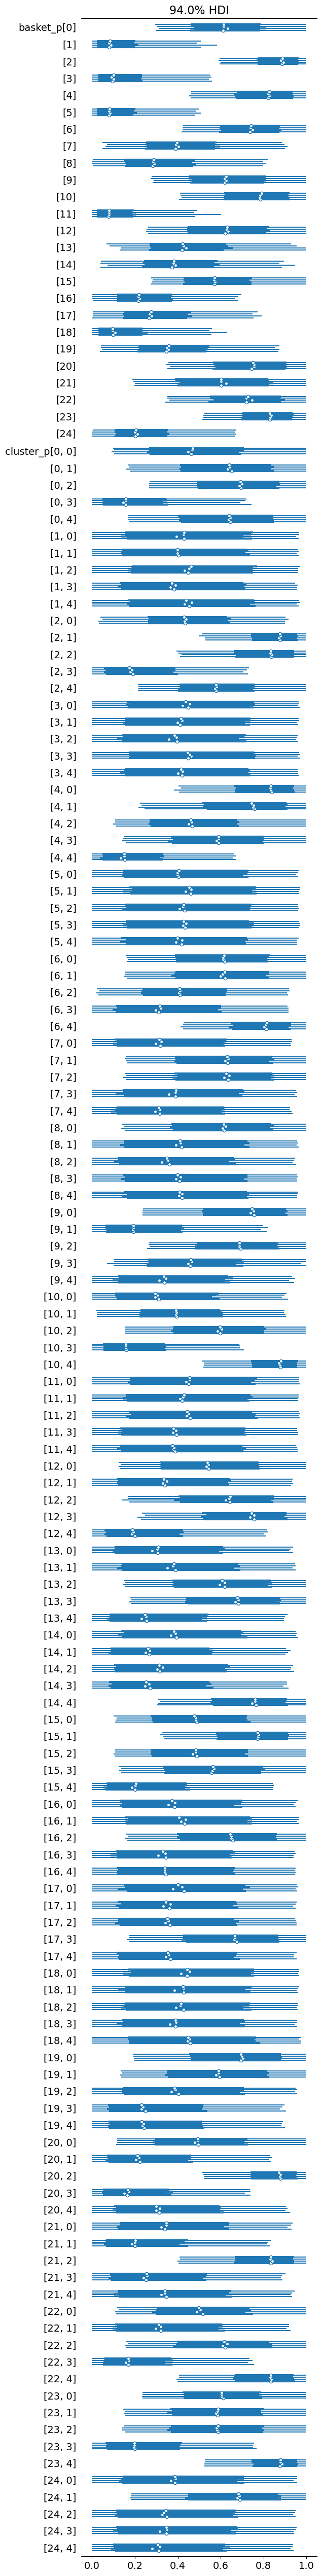

In [54]:
az.plot_forest(trace_h1, var_names=['basket_p', 'cluster_p'])

In [58]:
stacked_h1 = az.extract(trace_h1)

In [60]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)
true_basket_p[:, 0].shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p[:, 0], inferred_basket_p))

((25,), (25,), 0.2596873835191821)

In [61]:
inferred_cluster_p = np.mean(stacked_h1.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 5), (25, 5), 0.29684897015451145)

In [62]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h1 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 5), (25, 5), (25, 5))

### Hierarchical model 2

Another hierarchical model, but modelling the log-odds instead.

In [99]:
basket_coords = data_df['tissues'].unique() if 'tissues' in data_df.columns.values else \
    data_df['basket_number'].unique()
cluster_coords = data_df['cluster_number'].unique()
coords = {'basket': basket_coords, 'cluster': cluster_coords}

with pm.Model(coords=coords) as model_h2:
    # Define hyper-priors
    μ_basket = pm.Normal('basket_mu', mu=0, sigma=2)
    μ_cluster = pm.Normal('cluster_mu', mu=0, sigma=2)
    σ_basket = pm.HalfNormal('basket_sigma', sigma=1)
    σ_cluster = pm.HalfNormal('cluster_sigma', sigma=1)

    # Define priors
    basket_θ = pm.Normal('basket_theta', mu=μ_basket, sigma=σ_basket, dims='basket')
    cluster_θ = pm.Normal('cluster_theta', mu=μ_cluster, sigma=σ_cluster, dims=('basket', 'cluster'))

    basket_p = pm.Deterministic('basket_p', pm.math.invlogit(basket_θ), dims='basket')
    cluster_p = pm.Deterministic('cluster_p', pm.math.invlogit(cluster_θ), dims=('basket', 'cluster'))

    # responsive is a product of each combination of basket and cluster probabilities
    basket_idx = data_df['basket_number'].values
    cluster_idx = data_df['cluster_number'].values
    is_responsive = data_df['responsive'].values

    p = basket_p[basket_idx] * cluster_p[basket_idx, cluster_idx]
    y = pm.Bernoulli('y', p=p, observed=is_responsive)

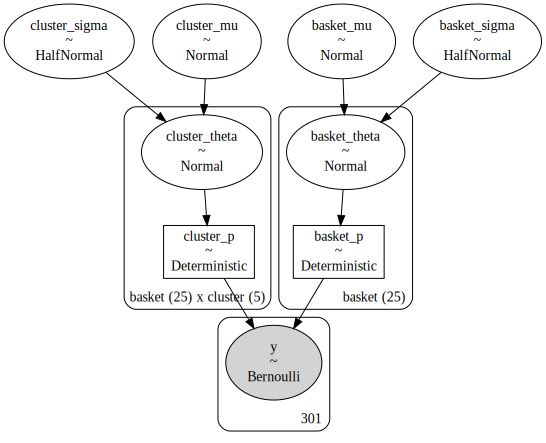

In [100]:
pm.model_to_graphviz(model_h2)

In [101]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [102]:
basket_coords = data_df['tissues'].unique() if 'tissues' in data_df.columns.values else \
    data_df['basket_number'].unique()
cluster_coords = data_df['cluster_number'].unique()
coords = {'basket': basket_coords, 'cluster': cluster_coords}

with pm.Model(coords=coords) as model_h2_nc:
    z_basket = pm.Normal('z_basket', mu=0, sigma=1, dims='basket')
    z_cluster = pm.Normal('z_cluster', mu=0, sigma=1, dims=('basket', 'cluster'))

    # Define hyper-priors
    μ_basket = pm.Normal('basket_mu', mu=0, sigma=2)
    μ_cluster = pm.Normal('cluster_mu', mu=0, sigma=2)
    σ_basket = pm.HalfNormal('basket_sigma', sigma=1)
    σ_cluster = pm.HalfNormal('cluster_sigma', sigma=1)

    # Define priors
    basket_θ = μ_basket + (z_basket * σ_basket)
    cluster_θ = μ_cluster + (z_cluster * σ_cluster)

    basket_p = pm.Deterministic('basket_p', pm.math.invlogit(basket_θ), dims='basket')
    cluster_p = pm.Deterministic('cluster_p', pm.math.invlogit(cluster_θ), dims=('basket', 'cluster'))

    # responsive is a product of each combination of basket and cluster probabilities
    basket_idx = data_df['basket_number'].values
    cluster_idx = data_df['cluster_number'].values
    is_responsive = data_df['responsive'].values

    p = basket_p[basket_idx] * cluster_p[basket_idx, cluster_idx]
    y = pm.Bernoulli('y', p=p, observed=is_responsive)

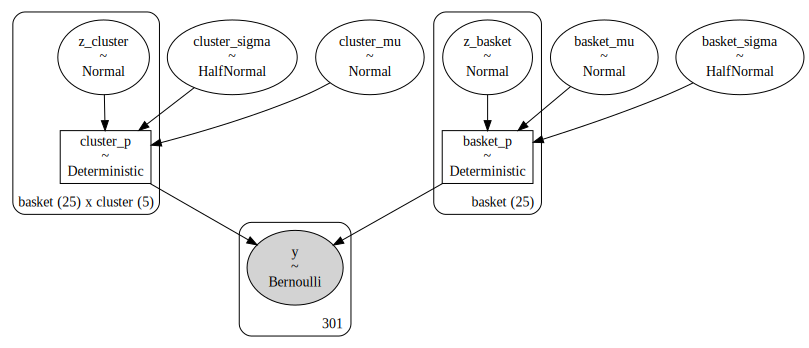

In [103]:
pm.model_to_graphviz(model_h2_nc)

In [104]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 118 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.714, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [105]:
az.summary(trace_h2).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z_basket[0]       0.47  0.69   -0.86     1.76       0.00      0.0   24350.0   
z_basket[1]      -1.01  0.83   -2.62     0.51       0.01      0.0   24364.0   
z_basket[2]       1.19  0.71   -0.07     2.62       0.01      0.0   15581.0   
z_basket[3]      -0.90  0.85   -2.54     0.67       0.01      0.0   21746.0   
z_basket[4]       0.84  0.73   -0.50     2.25       0.00      0.0   19284.0   
...                ...   ...     ...      ...        ...      ...       ...   
cluster_p[24, 0]  0.52  0.26    0.12     1.00       0.00      0.0    8857.0   
cluster_p[24, 1]  0.59  0.23    0.23     1.00       0.00      0.0   11632.0   
cluster_p[24, 2]  0.51  0.26    0.11     1.00       0.00      0.0    8352.0   
cluster_p[24, 3]  0.51  0.26    0.11     1.00       0.00      0.0    8280.0   
cluster_p[24, 4]  0.50  0.26    0.10     1.00       0.00      0.0    8056.0   

                  ess_tail  r_hat  
z_basket[0]        17527.0    1.0  
z_basket[1]        14788.0    1.0  
z_basket[2]        10165.0    1.0  
z_basket[3]        15868.0    1.0  
z_basket[4]        13101.0    1.0  
...                    ...    ...  
cluster_p[24, 0]   15522.0    1.0  
cluster_p[24, 1]   16598.0    1.0  
cluster_p[24, 2]   14894.0    1.0  
cluster_p[24, 3]   14326.0    1.0  
cluster_p[24, 4]   14071.0    1.0  

[304 rows x 9 columns]

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (150) in plot_ess, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

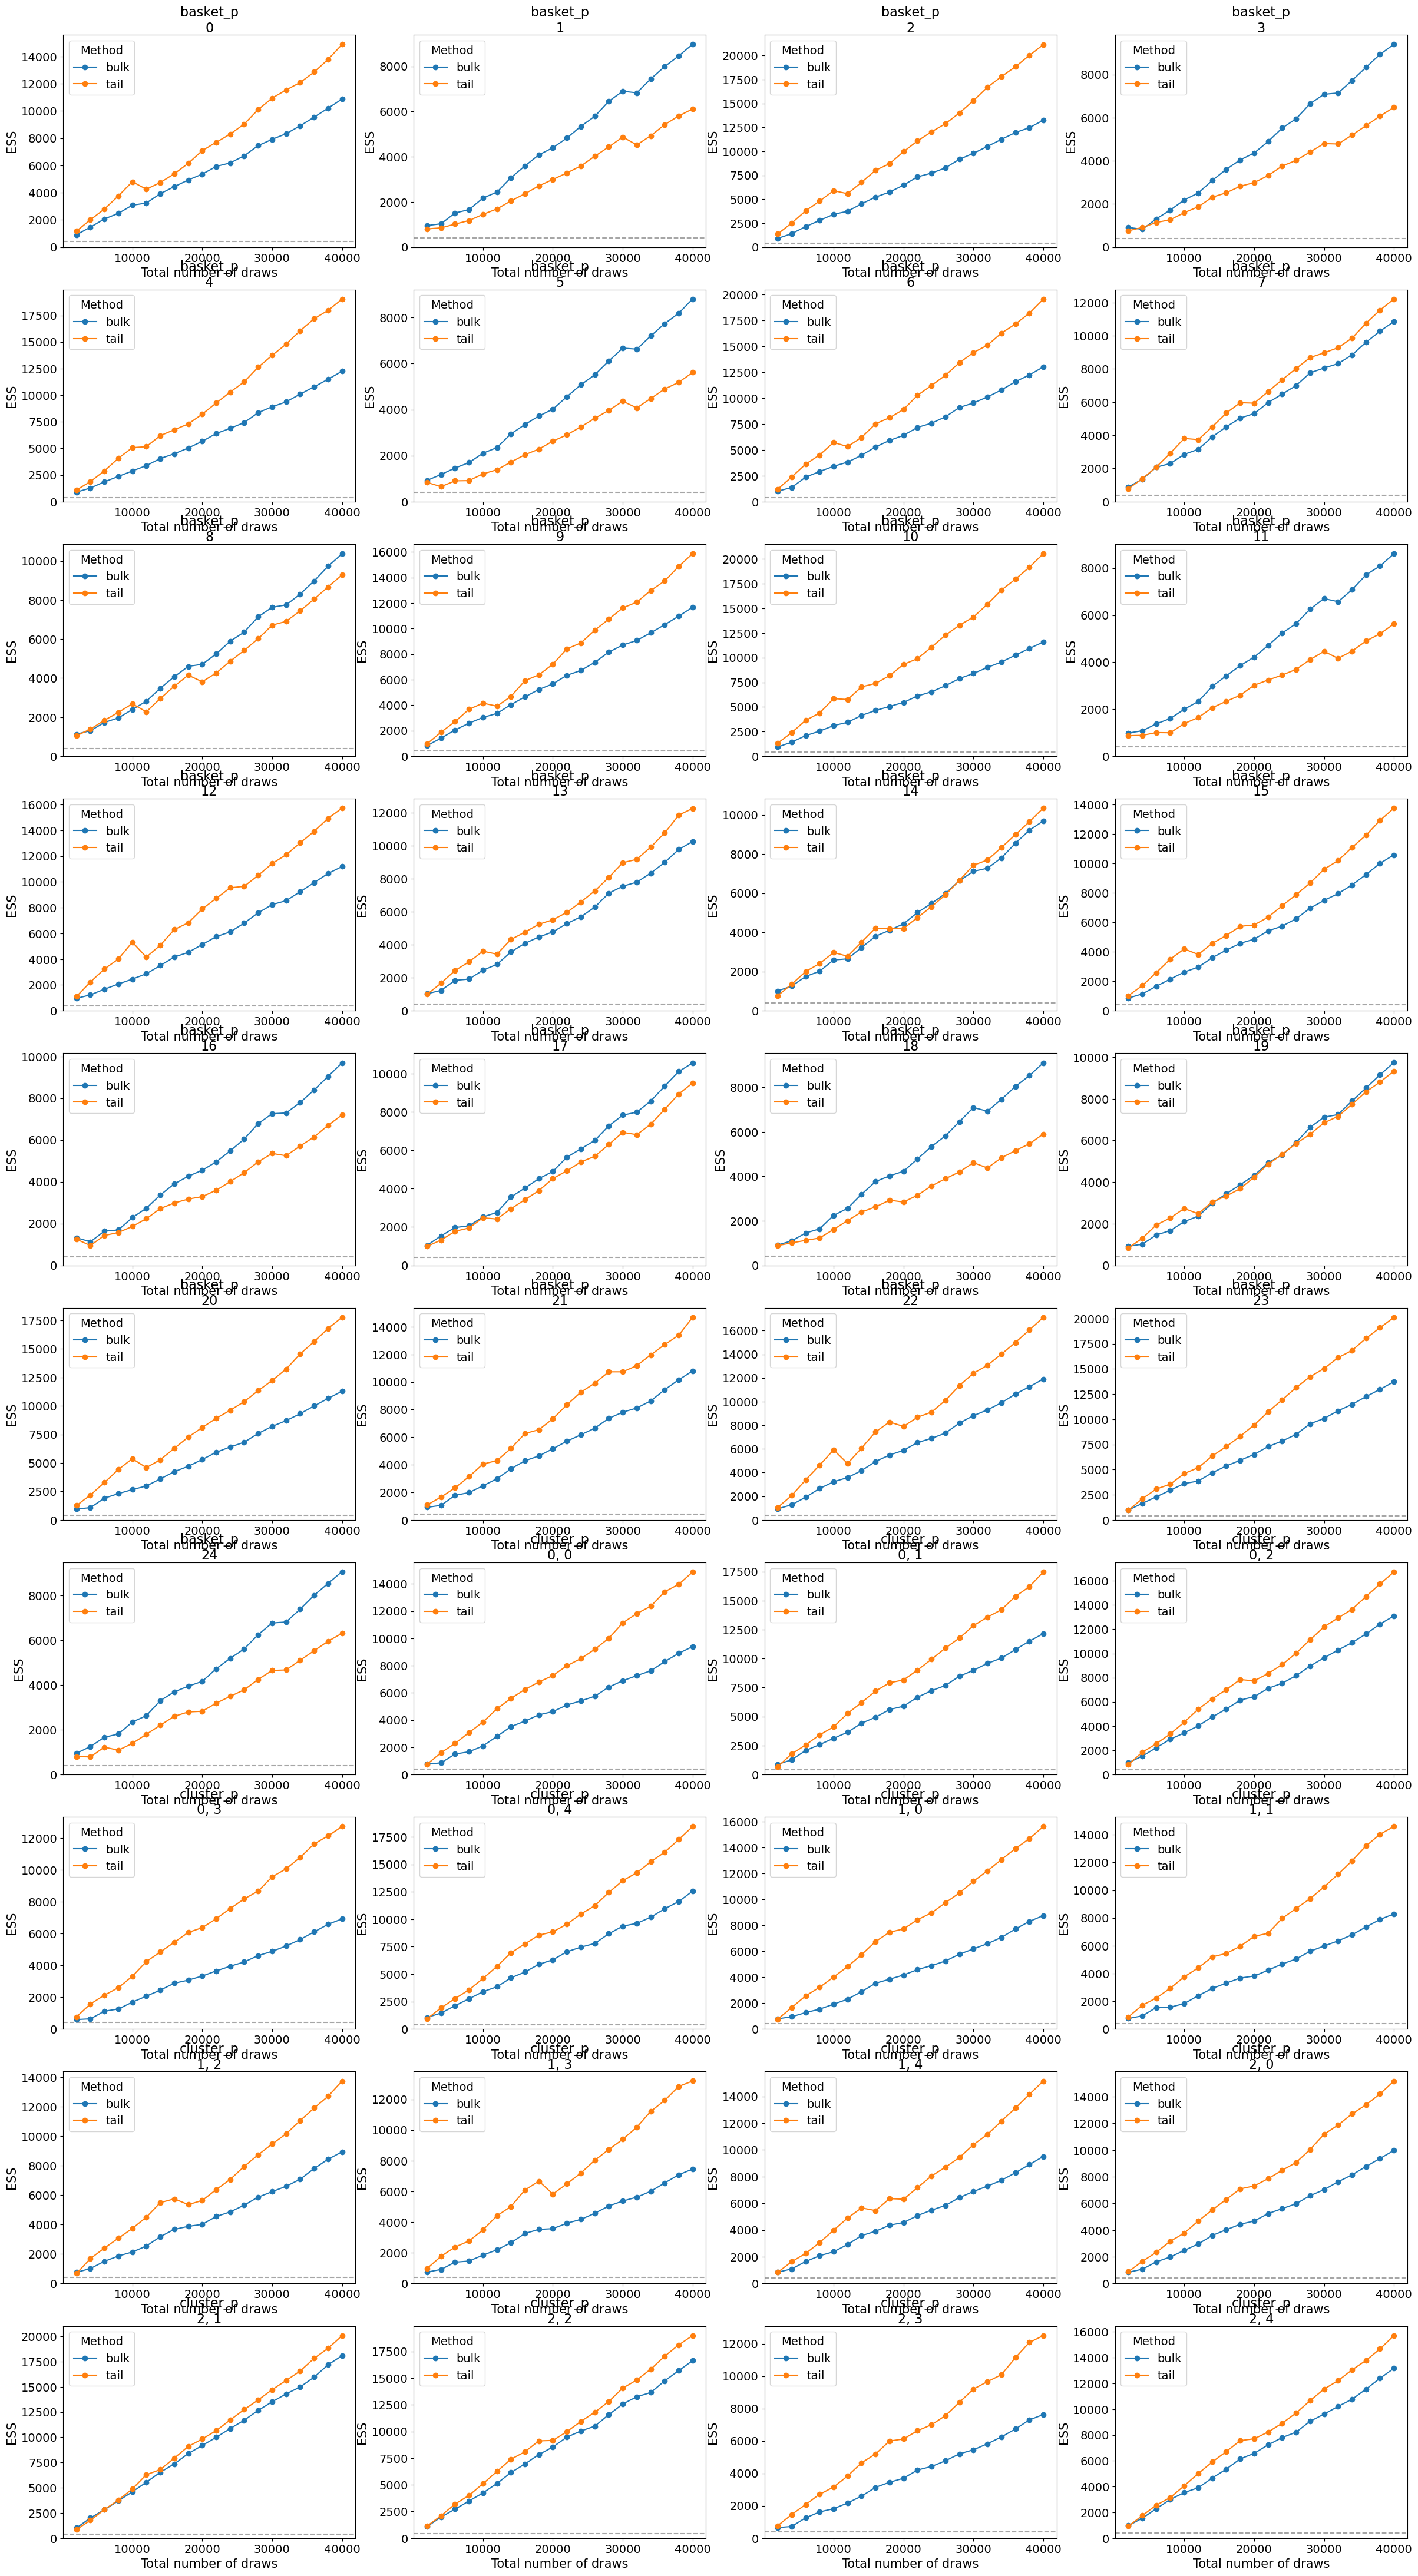

In [106]:
az.plot_ess(
    trace_h2, kind="evolution", var_names=['basket_p', 'cluster_p']
)

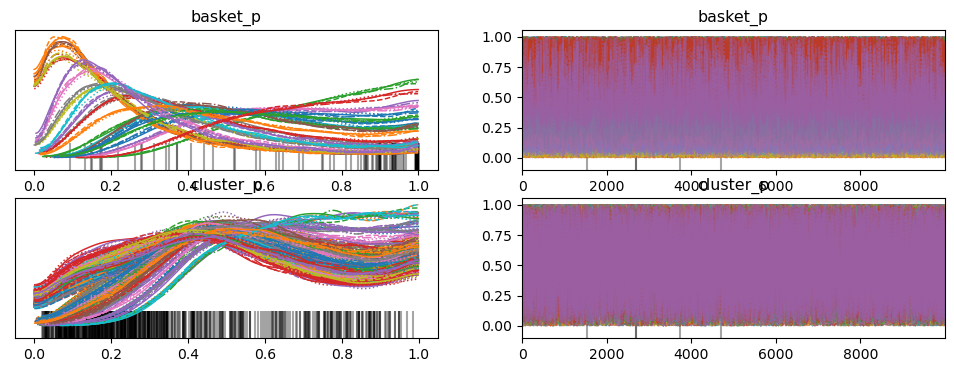

In [107]:
az.plot_trace(trace_h2, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

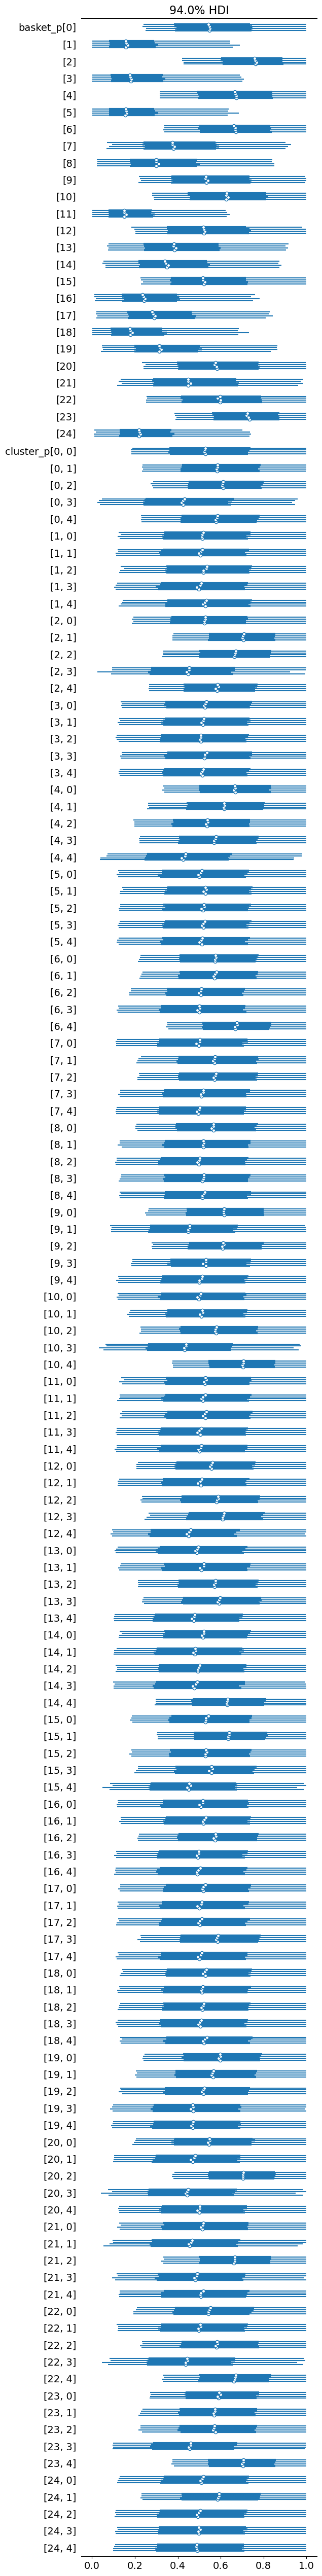

In [108]:
az.plot_forest(trace_h2, var_names=['basket_p', 'cluster_p'])

In [109]:
stacked_h2 = az.extract(trace_h2)

In [110]:
inferred_basket_p = np.mean(stacked_h2.basket_p.values, axis=1)
true_basket_p[:, 0].shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p[:, 0], inferred_basket_p))

((25,), (25,), 0.20645545364720563)

In [111]:
inferred_cluster_p = np.mean(stacked_h2.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 5), (25, 5), 0.2292265759299312)

In [112]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h2 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_s.shape

((25, 5), (25, 5), (25, 5))

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [113]:
actual = true_basket_p[:, 0]

predicted = np.mean(stacked_s.basket_p.values, axis=1)
rmse_s = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h1.basket_p.values, axis=1)
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h2.basket_p.values, axis=1)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted))

rmse_basket_p = pd.DataFrame({
    'method': ['s', 'h1', 'h2'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

method      RMSE
0      s  0.242603
1     h1  0.259687
2     h2  0.206455

Calculate root mean squared error for cluster_p

In [114]:
actual = true_cluster_p

predicted = np.mean(stacked_s.cluster_p.values, axis=2)
rmse_s = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h1.cluster_p.values, axis=2)
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_h2.cluster_p.values, axis=2)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted))

rmse_cluster_p = pd.DataFrame({
    'method': ['s', 'h1', 'h2'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_cluster_p

method      RMSE
0      s  0.282240
1     h1  0.296849
2     h2  0.229227

Make plot

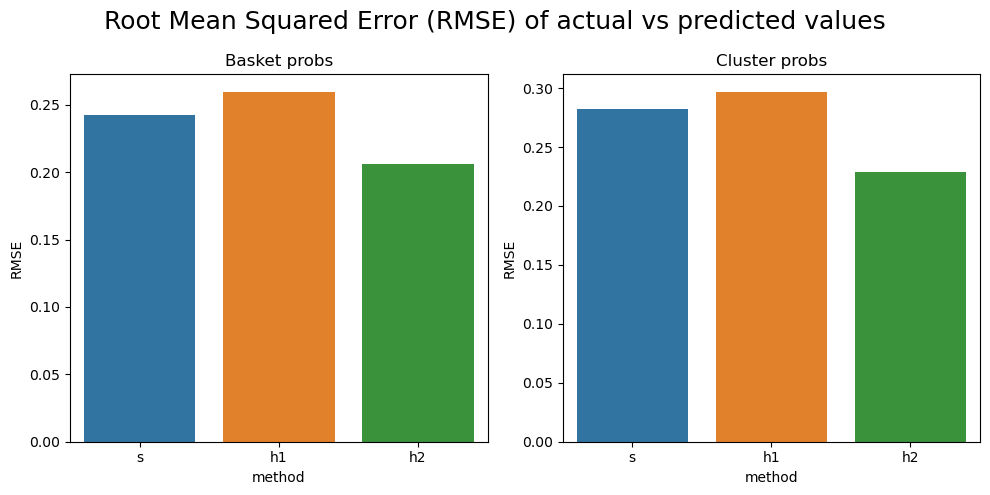

In [115]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Basket probs')

sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax2)
ax2.set_title('Cluster probs')

plt.suptitle('Root Mean Squared Error (RMSE) of actual vs predicted values', size=18)
plt.tight_layout()

Compare the matrices

Text(1452.626811594203, 0.5, 'Baskets')

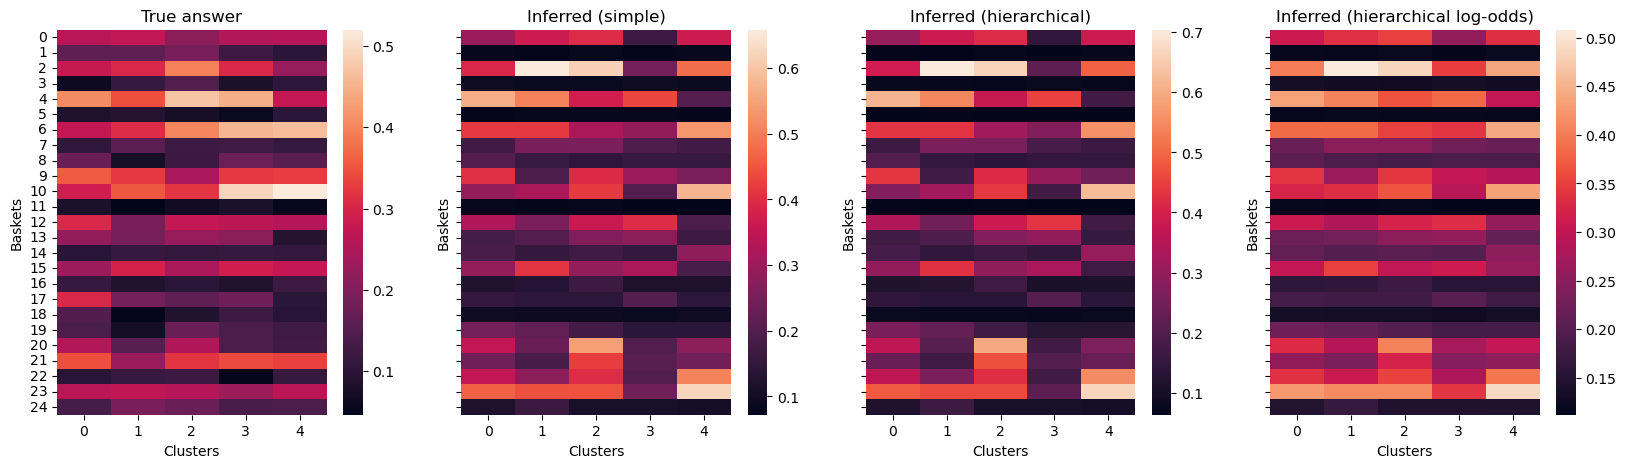

In [116]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_mat, ax=ax[0])
ax[0].set_title('True answer')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h2, ax=ax[3])
ax[3].set_title('Inferred (hierarchical log-odds)')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Check top and bottom partitions

In [117]:
def get_indices(arr, N):
    # Get the indices of the top-3 largest values
    top_indices = np.argpartition(arr, -N, axis=None)[-N:]
    top_indices = np.unravel_index(top_indices, arr.shape)

    # Get the indices of the top-3 smallest values
    bottom_indices = np.argpartition(arr, N, axis=None)[:N]
    bottom_indices = np.unravel_index(bottom_indices, arr.shape)

    return top_indices, bottom_indices

In [118]:
def count_overlap(true_indices, inferred_indices):
    a = set(zip(true_indices[0], true_indices[1]))
    b = set(zip(inferred_indices[0], inferred_indices[1]))
    return a.intersection(b)

In [119]:
plot_data = []
for N in list(range(5, 55, 5)):

    true_top_indices, true_bottom_indices = get_indices(true_mat, N)

    inferred_top_indices_s, inferred_bottom_indices_s = get_indices(inferred_mat_s, N)
    inferred_top_indices_h1, inferred_bottom_indices_h1 = get_indices(inferred_mat_h1, N)
    inferred_top_indices_h2, inferred_bottom_indices_h2 = get_indices(inferred_mat_h2, N)

    top_overlap_s = len(count_overlap(true_top_indices, inferred_top_indices_s))
    bottom_overlap_s = len(count_overlap(true_bottom_indices, inferred_bottom_indices_s))    
    plot_data.append(['s', top_overlap_s, bottom_overlap_s, (top_overlap_s+bottom_overlap_s), N])

    top_overlap_h1 = len(count_overlap(true_top_indices, inferred_top_indices_h1))
    bottom_overlap_h1 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h1))
    plot_data.append(['h1', top_overlap_h1, bottom_overlap_h1, (top_overlap_h1+bottom_overlap_h1), N])

    top_overlap_h2 = len(count_overlap(true_top_indices, inferred_top_indices_h2))
    bottom_overlap_h2 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h2))
    plot_data.append(['h2', top_overlap_h2, bottom_overlap_h2, (top_overlap_h2+bottom_overlap_h2), N])
    
df = pd.DataFrame(plot_data, columns=['method', 'top', 'bottom', 'total', 'N'])
df

method  top  bottom  total   N
0       s    1       1      2   5
1      h1    1       1      2   5
2      h2    1       2      3   5
3       s    4       5      9  10
4      h1    4       4      8  10
5      h2    4       4      8  10
6       s    6       8     14  15
7      h1    6       8     14  15
8      h2    5       8     13  15
9       s    9      10     19  20
10     h1    9      10     19  20
11     h2    8      10     18  20
12      s   11      16     27  25
13     h1   11      16     27  25
14     h2   12      16     28  25
15      s   14      18     32  30
16     h1   14      18     32  30
17     h2   16      17     33  30
18      s   22      21     43  35
19     h1   22      21     43  35
20     h2   21      22     43  35
21      s   29      24     53  40
22     h1   28      24     52  40
23     h2   29      24     53  40
24      s   33      30     63  45
25     h1   33      30     63  45
26     h2   35      29     64  45
27      s   37      36     73  50
28     h1   36      37     73  50
29     h2   41      35     76  50

Text(0.5, 1.0, 'Correct most-responsive partitions')

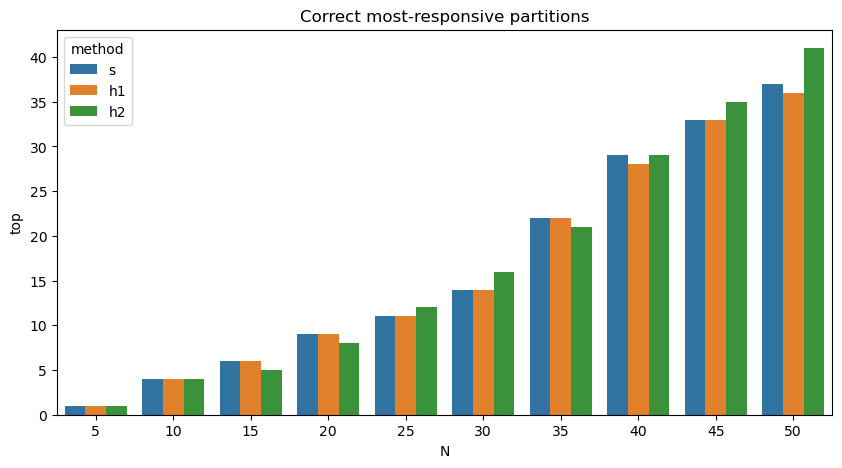

In [120]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='top', data=df, hue='method')
plt.title('Correct most-responsive partitions')

Text(0.5, 1.0, 'Correct least-responsive partitions')

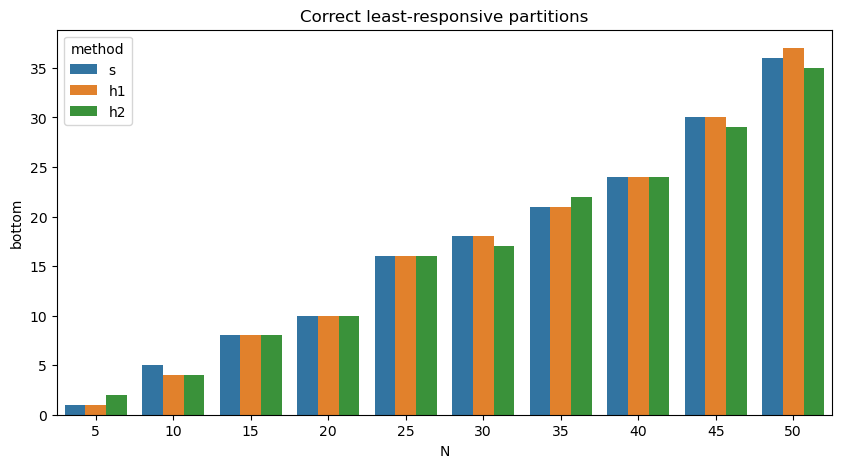

In [121]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='bottom', data=df, hue='method')
plt.title('Correct least-responsive partitions')

## 4. Model comparison

In [122]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [123]:
loo_s = az.loo(trace_s)
loo_s

Computed from 40000 posterior samples and 301 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -153.03     9.32
p_loo       37.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      289   96.0%
 (0.5, 0.7]   (ok)         12    4.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [124]:
loo_h1 = az.loo(trace_h1)
loo_h1

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 40000 posterior samples and 301 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -155.17    10.12
p_loo       44.80        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      265   88.0%
 (0.5, 0.7]   (ok)         33   11.0%
   (0.7, 1]   (bad)         3    1.0%
   (1, Inf)   (very bad)    0    0.0%

In [125]:
loo_h2 = az.loo(trace_h2)
loo_h2

Computed from 40000 posterior samples and 301 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -155.41     9.04
p_loo       24.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      297   98.7%
 (0.5, 0.7]   (ok)          4    1.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [126]:
ic = 'loo'
df_comp_loo = az.compare({
    's': loo_s, 
    'h1': loo_h1,
    'h2': loo_h2,    
}, ic=ic)
df_comp_loo

rank    elpd_loo      p_loo  elpd_diff        weight         se       dse  \
s      0 -153.025264  37.151685   0.000000  1.000000e+00   9.316088  0.000000   
h1     1 -155.169272  44.804211   2.144008  1.110223e-16  10.116121  1.056428   
h2     2 -155.409605  24.145168   2.384341  0.000000e+00   9.043647  1.984103   

    warning scale  
s     False   log  
h1     True   log  
h2    False   log

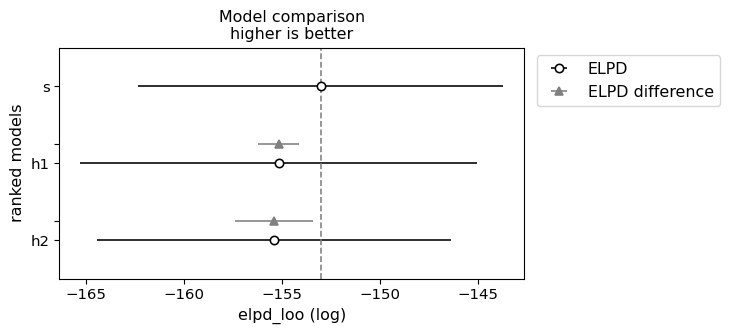

In [127]:
az.plot_compare(df_comp_loo);